# 02. Comparing Experiments

**Note**: the appearance of this notebook will depend on the environment and screen size you're using. If the tables are being clipped or the figures look off, consider trying Google Colab or Github via the buttons below. This notebook was created in VSCode, and will likely look best locally.

<a target="_blank" href="https://colab.research.google.com/github/ioverho/prob_conf_mat/blob/main/docs/Getting%20Started/02_comparing_experiments.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/Run_in_Colab-_?style=for-the-badge&logo=googlecolab&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fprob_conf_mat%2Fblob%2Fmain%2Fdocs%2FGetting%2520Started%2F02_comparing_experiments.ipynb">
</a>
<a target="_blank" href="https://github.com/ioverho/prob_conf_mat/blob/main/docs/Getting%20Started/02_comparing_experiments.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/View_in_Github-_?style=for-the-badge&logo=github&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fprob_conf_mat%2Fblob%2Fmain%2Fdocs%2FGetting%2520Started%2F02_comparing_experiments.ipynb">
</a>


In [ ]:
# Only run in Google Colab
#%pip install prob_conf_mat

## Setup

Now consider the following common scenario. We train two different models, A and B, on the same dataset. Here model A is our brilliantly designed model, and B is the boring baseline. Now we want to test if our model (A) is a significant improvement over the baseline. To do so, we apply the two models to the held-out test set independently and get the following confusion matrices:

In [1]:
confusion_matrix_a = [
    [2508, 70, 102, 42],
    [22, 3820, 421, 36],
    [14, 202, 3071, 11],
    [37, 9, 6, 199],
]

confusion_matrix_b = [
    [2482, 75, 106, 59],
    [30, 3813, 423, 33],
    [22, 239, 3030, 7],
    [34, 13, 13, 191],
]


To assess how much better model A is relative to model B, we use a classification metric on the two confusion matrices, for example Matthew's Correlation Coefficient (MCC). If MCC is higher for model A, we can publish our paper, and get it accepted without reviewers complaining, right?

In [2]:
import prob_conf_mat as pcm

study = pcm.Study(
    seed=0,
    num_samples=10000,
    ci_probability=0.95,
)

study.add_experiment("a", confusion_matrix_a, prevalence_prior=1.0, confusion_prior=1.0)

study.add_experiment("b", confusion_matrix_b, prevalence_prior=1.0, confusion_prior=1.0)

study.add_metric(metric="mcc")


In [3]:
study.report_metric_summaries(metric="mcc")


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
a,a,0.8641,0.8626,0.8635,"[0.8544, 0.8706]",0.0162,-0.0904,0.0979
b,b,0.8523,0.8510,0.8514,"[0.8424, 0.8594]",0.0170,-0.0588,0.0190


Great! When estimating MCC scores, it seems model A does outperform model B, and by a margin of $0.0116$ median MCC. Before we get on with writing our paper, however, note that the credible intervals overlap at the 95% credibility level. So while model A *is* better, this is not always the case. Then how much better is model A actually?

## Bayesian Hypothesis Testing

In the frequentist framework, situations like these call for hypothesis tests. For example, we want to compare the means of the different models' MCC scores, so we can run a t-test. But since we're not operating in the frequentist framework, and the distributions of the various metrics we compute likely invalidate the stringent assumptions that go along with these hypotheses tests, we instead have to a use a different framework.

Kruschke et al. approach the problem from a Bayesian modelling perspective in ['Kruschke in Bayesian Estimation Supersedes the *t* Test'](https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf). If we assume our samples from the two estimated posterior predictive distributions to be correct, we can estimate the difference between the two experiments by simply taking the differences of their samples. The produced difference distribution looks something like this:

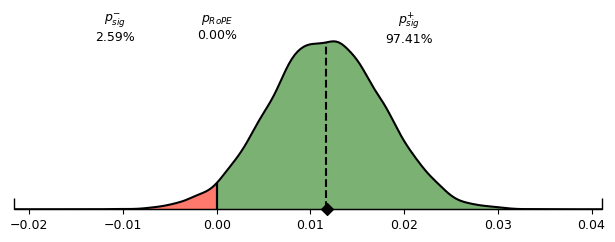

In [4]:
study.plot_pairwise_comparison(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.0,
);


The area in red corresponds to area where model B is better than model A, and the region in green where model A is better than model B. It's quite clear that model A is better *most of the time*, but is it enough to draw conclusions? Or do we need to test our models on a larger dataset? In other words, is this difference statistically significant, or just a 'lucky' outcome?

In [5]:
comparison_result = study.report_pairwise_comparison(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.00,
)

print(comparison_result)


Experiment a's mcc being greater than b could be considered 'likely'* (Median Δ=0.0116, 95.00% HDI=[0.0005, 0.0237], p_direction=97.41%).

There is a 100.00% probability that this difference is bidirectionally significant (ROPE=[-0.0000, 0.0000], p_ROPE=0.00%).

Bidirectional significance could be considered 'certain'*.

There is a 97.41% probability that this difference is significantly positive (p_pos=97.41%, p_neg=2.59%).

* These interpretations are based off of loose guidelines, and should change according to the application.


To test this, the first sentence of the above output is relevant. The median difference is $0.0116$, with the true difference falling somewhere in the range \[0.0005, 0.0237\] at the 95% credibility level. The $p_{\text{direction}}$ statistic is most relevant, being somewhat comparable to the frequentist $p$-value. At a value of $97.41$%, we can conclude that model A being better than model B is probable. More data is always better, but currently there's only a $\approx 2.50$% chance that model B is actually better.

## The Region of Practical Equivalence (ROPE)

That covers statistical significance, but what about practical significance? The apparent gain that model A books over model B is… modest to say the least.

On a large enough test set, even very small differences become statistically significant, even when the models are *practically* equivalent. To test for practical significance, we can construct a 'Region of Practical Equivalence' (ROPE). This is some region bounded by two minimally significant values, outside which we may conclude that the difference between the models is worth noting. Within the ROPE, however, we assume that the difference is not relevant.

For this example, a difference of at least $0.005$ MCC is needed for us to be convinced using model A is not a waste of time. We can now repeat the analysis, with a `min_sig_diff` parameter:

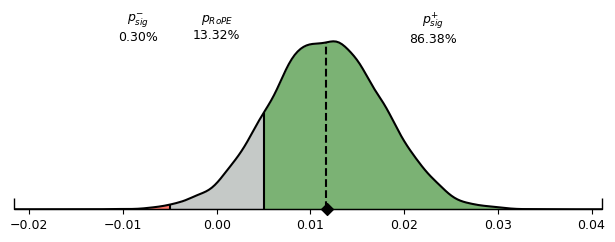

In [6]:
study.plot_pairwise_comparison(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.005,
);


All of a sudden there is a gray region around $0$. This is the ROPE. The green region is now the area corresponding to model A being practically significantly better than model B, and vice versa for the red region. While model A still appears to be better than model B, there is $13.32$% probability that that difference is practically 0, or in favour of model B.

In [7]:
comparison_result = study.report_pairwise_comparison(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.005,
)

print(comparison_result)


Experiment a's mcc being greater than b could be considered 'likely'* (Median Δ=0.0116, 95.00% HDI=[0.0005, 0.0237], p_direction=97.41%).

There is a 86.68% probability that this difference is bidirectionally significant (ROPE=[-0.0050, 0.0050], p_ROPE=13.32%).

Bidirectional significance could be considered 'undecided'*.

There is a 86.38% probability that this difference is significantly positive (p_pos=86.38%, p_neg=0.30%).

Relative to two random models (p_ROPE,random=47.27%) significance is 5.8337 times more likely.

* These interpretations are based off of loose guidelines, and should change according to the application.


If we don't care about the direction of significance (either model A or model B is better), practical significance is mostly undecided at an $86.68$% probability. Most of this difference is in favour of model A ($86.38$%), though. When comparing to the difference between random models on the same dataset, we see that practical significance is $3.55$ times more likely than not. Interpreting this as a [Bayes Factor](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation), this is usually seen as weak evidence.

All in all, while the difference likely does exist, it's not large enough to warrant celebration just yet. Of course, this is entirely dependent on the chosen minimally significant difference. If you decide that a much difference is already worth your time, the probabilities of practical significance will increase.

## Comparing to a Random Baseline

One important case to check is whether the trained classifier performs better than random. Early on during training, it won't be much better, but later on, the trained model should be much better.

The random baseline largely depends on (1) the classification metric used, and (2) the label proportion. Luckily, the Study class can simulate performance of a random classifier on this dataset for any implemented metric. For example, if using the MCC metric, we would expect random performance to be 0 exactly.

In [8]:
study.report_random_metric_summaries(metric="mcc")


Group,Experiment,Median,Mode,95.0% HDI,MU,Skew,Kurt
a,a,-0.0001,0.0015,"[-0.0120, 0.0099]",0.0219,-0.0150,0.0012
b,b,0.0000,-0.0004,"[-0.0109, 0.0111]",0.0220,0.0139,0.0430


And in fact, that is the value we (almost) retrieve.

Given the previous results, it seems trivial to compare the trained classifiers to the random ones, but this is possible.

In [9]:
study.report_pairwise_comparison_to_random(metric="mcc", min_sig_diff=0.05)


Group,Experiment,Median Δ,p_direction,ROPE,p_ROPE,p_sig
a,a,0.8627,1.0000,"[-0.0500, 0.0500]",0.0000,1.0000
b,b,0.8510,1.0000,"[-0.0500, 0.0500]",0.0000,1.0000


Here we can see that for both model A and model B, the achieved classification performance is **much** better than random.

## Next Steps

In the [next tutorial](https://ioverho.github.io/prob_conf_mat/Getting%20Started/03_aggregating_experiments.html), we'll cover how to aggregate the results from related experiments into an experiment group.

For more on statistical and effect size significance testing:

* Check out the [`Study` documentation](https://ioverho.github.io/prob_conf_mat/Reference/Study.html#comparing-2-experiments) on comparing two studies
* Check out the [how-to guide on comparing *many* experiments](https://ioverho.github.io/prob_conf_mat/How%20To%20Guides/comparing_many_experiments.html) at once, and explore a simple case study
* Check out the [explainer](https://ioverho.github.io/prob_conf_mat/Explanation/inference.html) on the theory behind statistical inference with metric distributions
* Check out the [`bayestestR` articles](https://easystats.github.io/bayestestR/articles/) on Bayesian hypothesis testing, indices of effect and significance, the RoPE, etc.